# Notebook 2 - Snow Accumulation and Melt

## Import Necessary Packages

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import os

## Make datelist
* This should be the same as the date range used in the data_download notebook

In [2]:
start_date = "2021-11-10"
end_date = "2021-12-10"
date_list = pd.date_range(start_date, end_date).to_list()

## Open precipitation and mean temperature files
Which we produced in the data download notebook!

In [3]:
precip = xr.open_dataset(f'climate_data/ppt_{start_date}-{end_date}.nc')
tmean = xr.open_dataset(f'climate_data/tmean_{start_date}-{end_date}.nc')

## Calculate Snow Accumulation and Snow Change
This project uses a simple snow model with a snow threshold, the temperature where rain becomes snow, and a melt factor, or the precipitation equivalent of snow which melts for every degree celsius over the snow threshold. Code comments describe the calculation process in more detail. It's worth noting that this does not account for rain-on-snow events, and also does not incorporate a temperature range for rain -> snow the way other models do.

In [4]:
snow_threshold = 0 # degrees celsius
mf = 20 # melt factor, mm precipitation equivalent/degree celsius 
        # that snow melts when T>snow threshold

# empty variable to append snow dataarrays to
nsd = [] # net snow delta
nsa = [] # net snow accumulation

#first day of precipitation and temperature from datasets
first_day_precip = precip['ppt'].sel(date=date_list[0])
first_day_temp = tmean['tmean'].sel(date=date_list[0])

# first day snow accumulation
first_day_snowfall = np.where(first_day_temp < snow_threshold, first_day_precip, 0)

# the first day of net snow accumulation into a data array
net_snow_da = xr.DataArray(first_day_snowfall,
                            dims=['lon', 'lat'],
                            coords={'lat': precip.lat.values,
                                    'lon': precip.lon.values})

# add date
net_snow_da = net_snow_da.expand_dims(dim = 'date')
net_snow_da.coords['date'] = ('date', [date_list[0]])

# assumption: initial snow is 0 across basin (likely flawed)
# change in snow is just equal to the accumulation of that day
nsd.append(net_snow_da)
nsa.append(net_snow_da)

# iterate through the rest of the dates
for date in date_list[1:]:
    # get precip and temp for the current day in the loop
    date_precip = precip['ppt'].sel(date=date)
    date_temp = tmean['tmean'].sel(date=date)
    
    # get net snowfall/melt for the day
    # if temperature is less than snow threshold, all precip falls as snow
    date_snowfall = np.where(date_temp < snow_threshold, date_precip, 0)
    
    # if temperature is more than the snow threshold, snow melts at a rate determined
    # by the melt factor
    date_snowmelt = np.where(date_temp > snow_threshold, mf*(date_temp - snow_threshold), 0)
    net_snow_for_day = date_snowfall - date_snowmelt
    
    # snow today = snow yesterday plus change in snow today
    net_snow_total = net_snow_da + net_snow_for_day
    
    # find negative values and remove them (can't have negative snow)
    net_snow_idx = (net_snow_total < 0)
    net_snow_total = xr.where(net_snow_idx, 0, net_snow_total)
    
    # calculate snow today - snow yesterday to get daily change in snow
    net_snow_change = net_snow_total - net_snow_da
    
    # record daily snow change to data array
    deltasnow_perday = xr.DataArray(net_snow_change,
                            dims=['date', 'lon', 'lat'],
                            coords={'date': [date],
                                    'lat': precip.lat.values,
                                    'lon': precip.lon.values})
    
    # record total snow accumulation to data array
    net_snow_da = xr.DataArray(net_snow_total,
                            dims=['date', 'lon', 'lat'],
                            coords={'date': [date],
                                    'lat': precip.lat.values,
                                    'lon': precip.lon.values})
    
    # append net snow delta and net snow accumulation
    nsd.append(deltasnow_perday)
    nsa.append(net_snow_da)
    

# make netcdf of daily snow change (which would add to or subtract from runoff)
daily_snow_change = xr.concat(nsd, 'date')
daily_snow_change.to_netcdf(path=os.path.join('climate_data/', f'snow_change_{start_date}-{end_date}.nc'))

# make netcdf of daily snow pack
# not sure if this is necessary... but i accidentally originally did it this way
final_snow = xr.concat(nsa, 'date')
outstring = os.path.join('climate_data/', f'snow_{start_date}-{end_date}.nc')

final_snow.to_netcdf(path=outstring)

## Plot Daily Snow Accumulation
* To me, it looks like too much snow is accumulating. This needs to be workshoped a good amount. 
* To do: use SNOTEL data to verify/disqualify. 

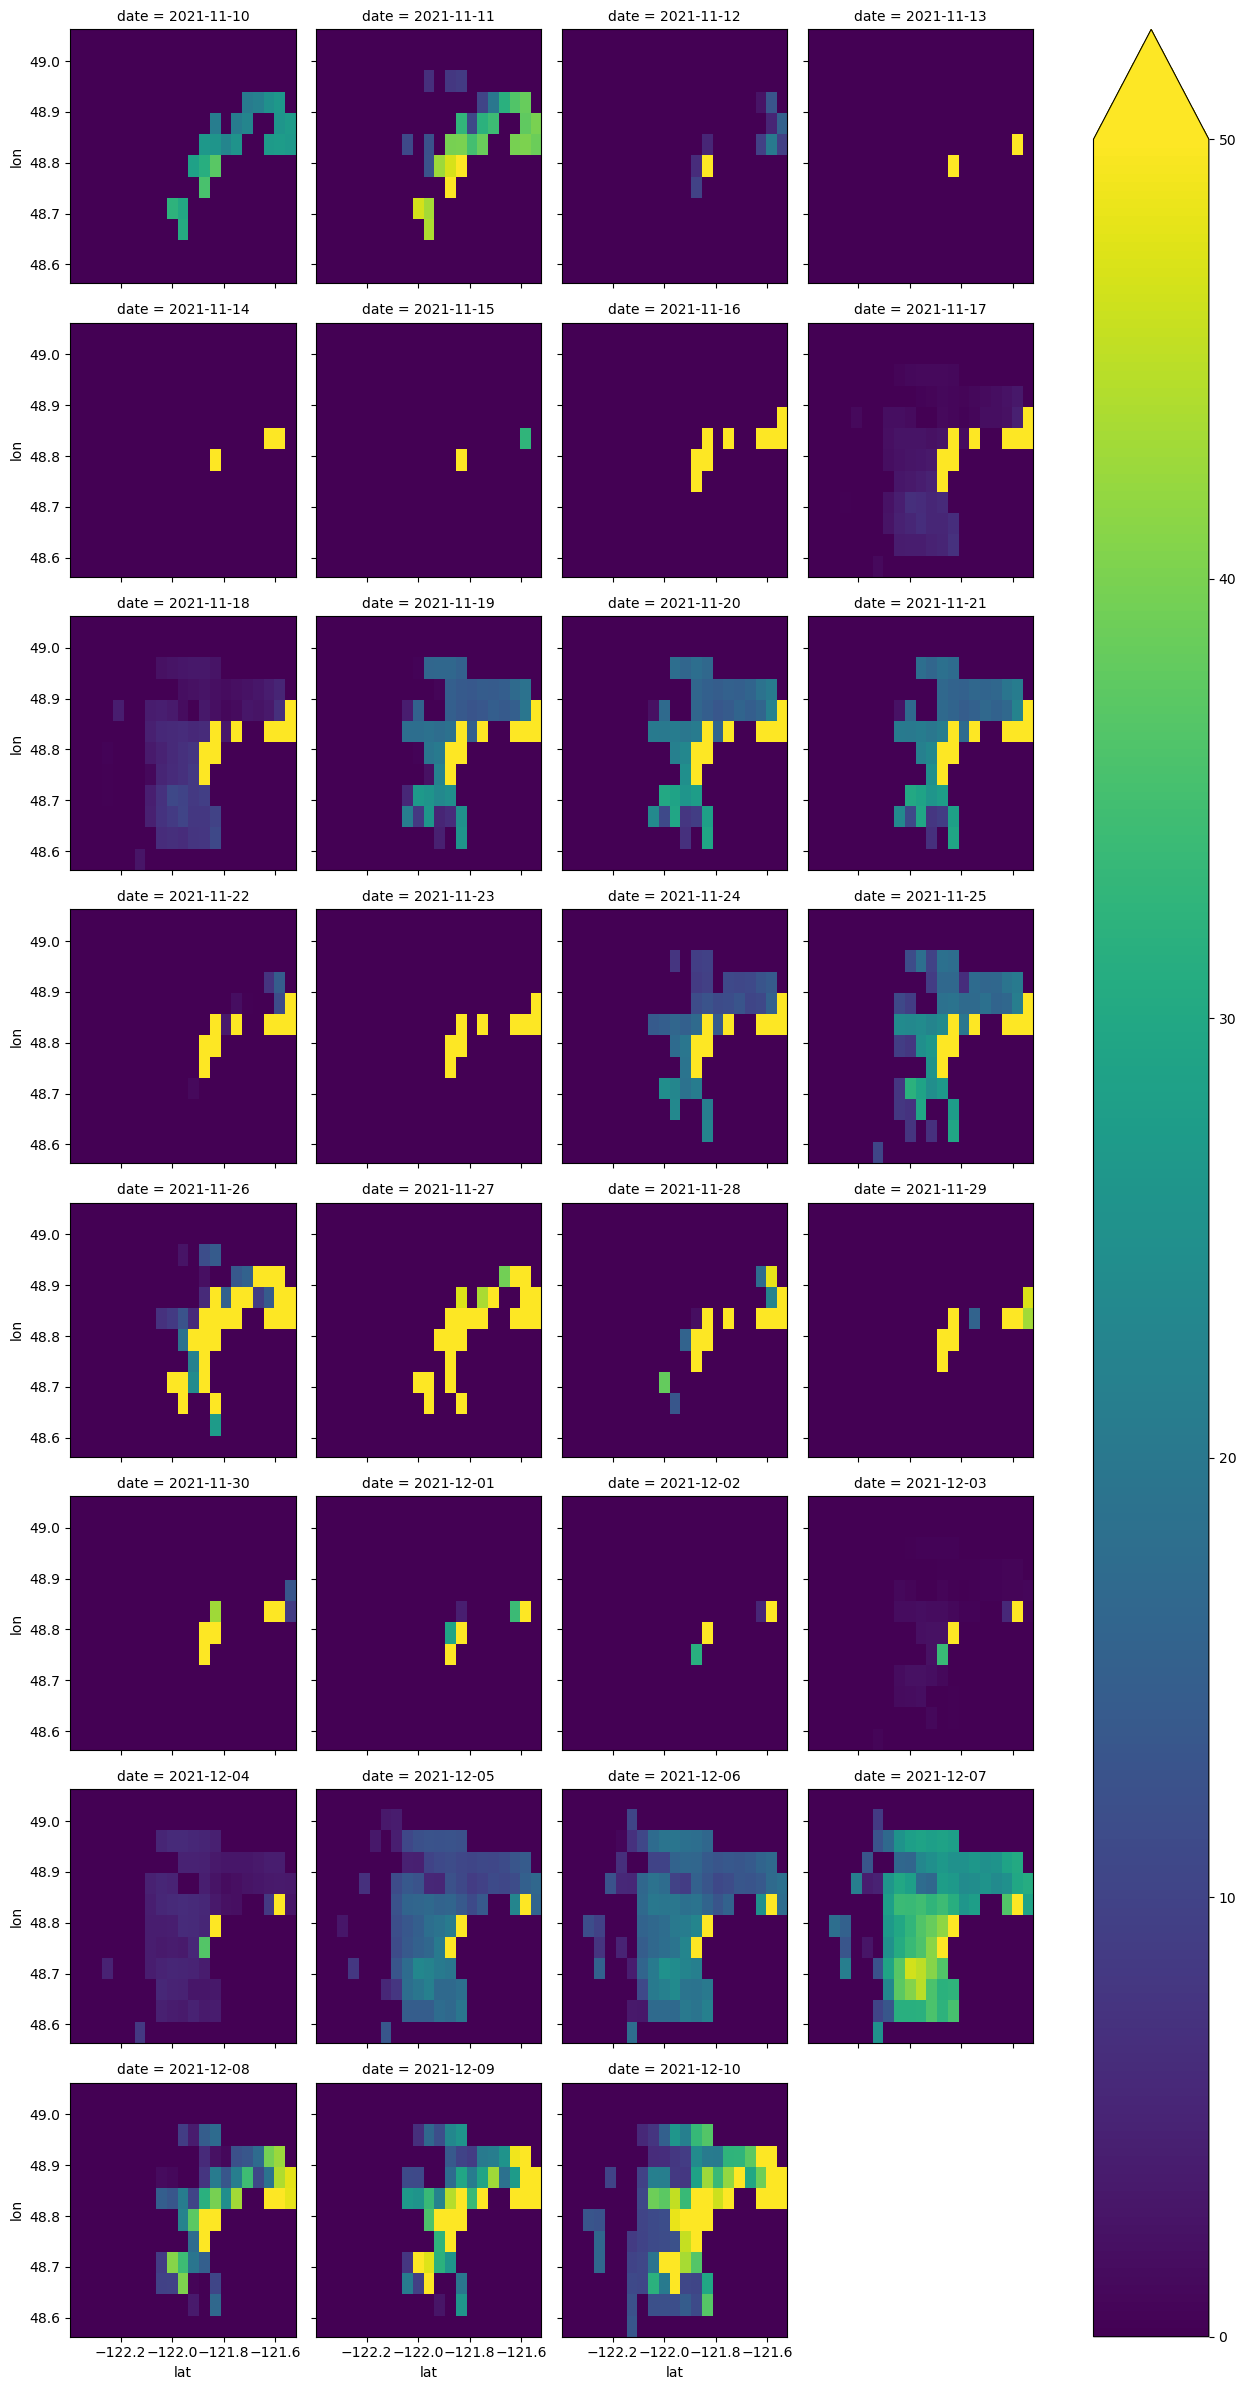

In [14]:
final_snow.isel(date=slice(0, 31, 1)).plot.imshow(col = 'date', col_wrap = 4, vmin = 0, vmax = 50)

## Plot daily change in snowpack
* This also doesn't look great to me

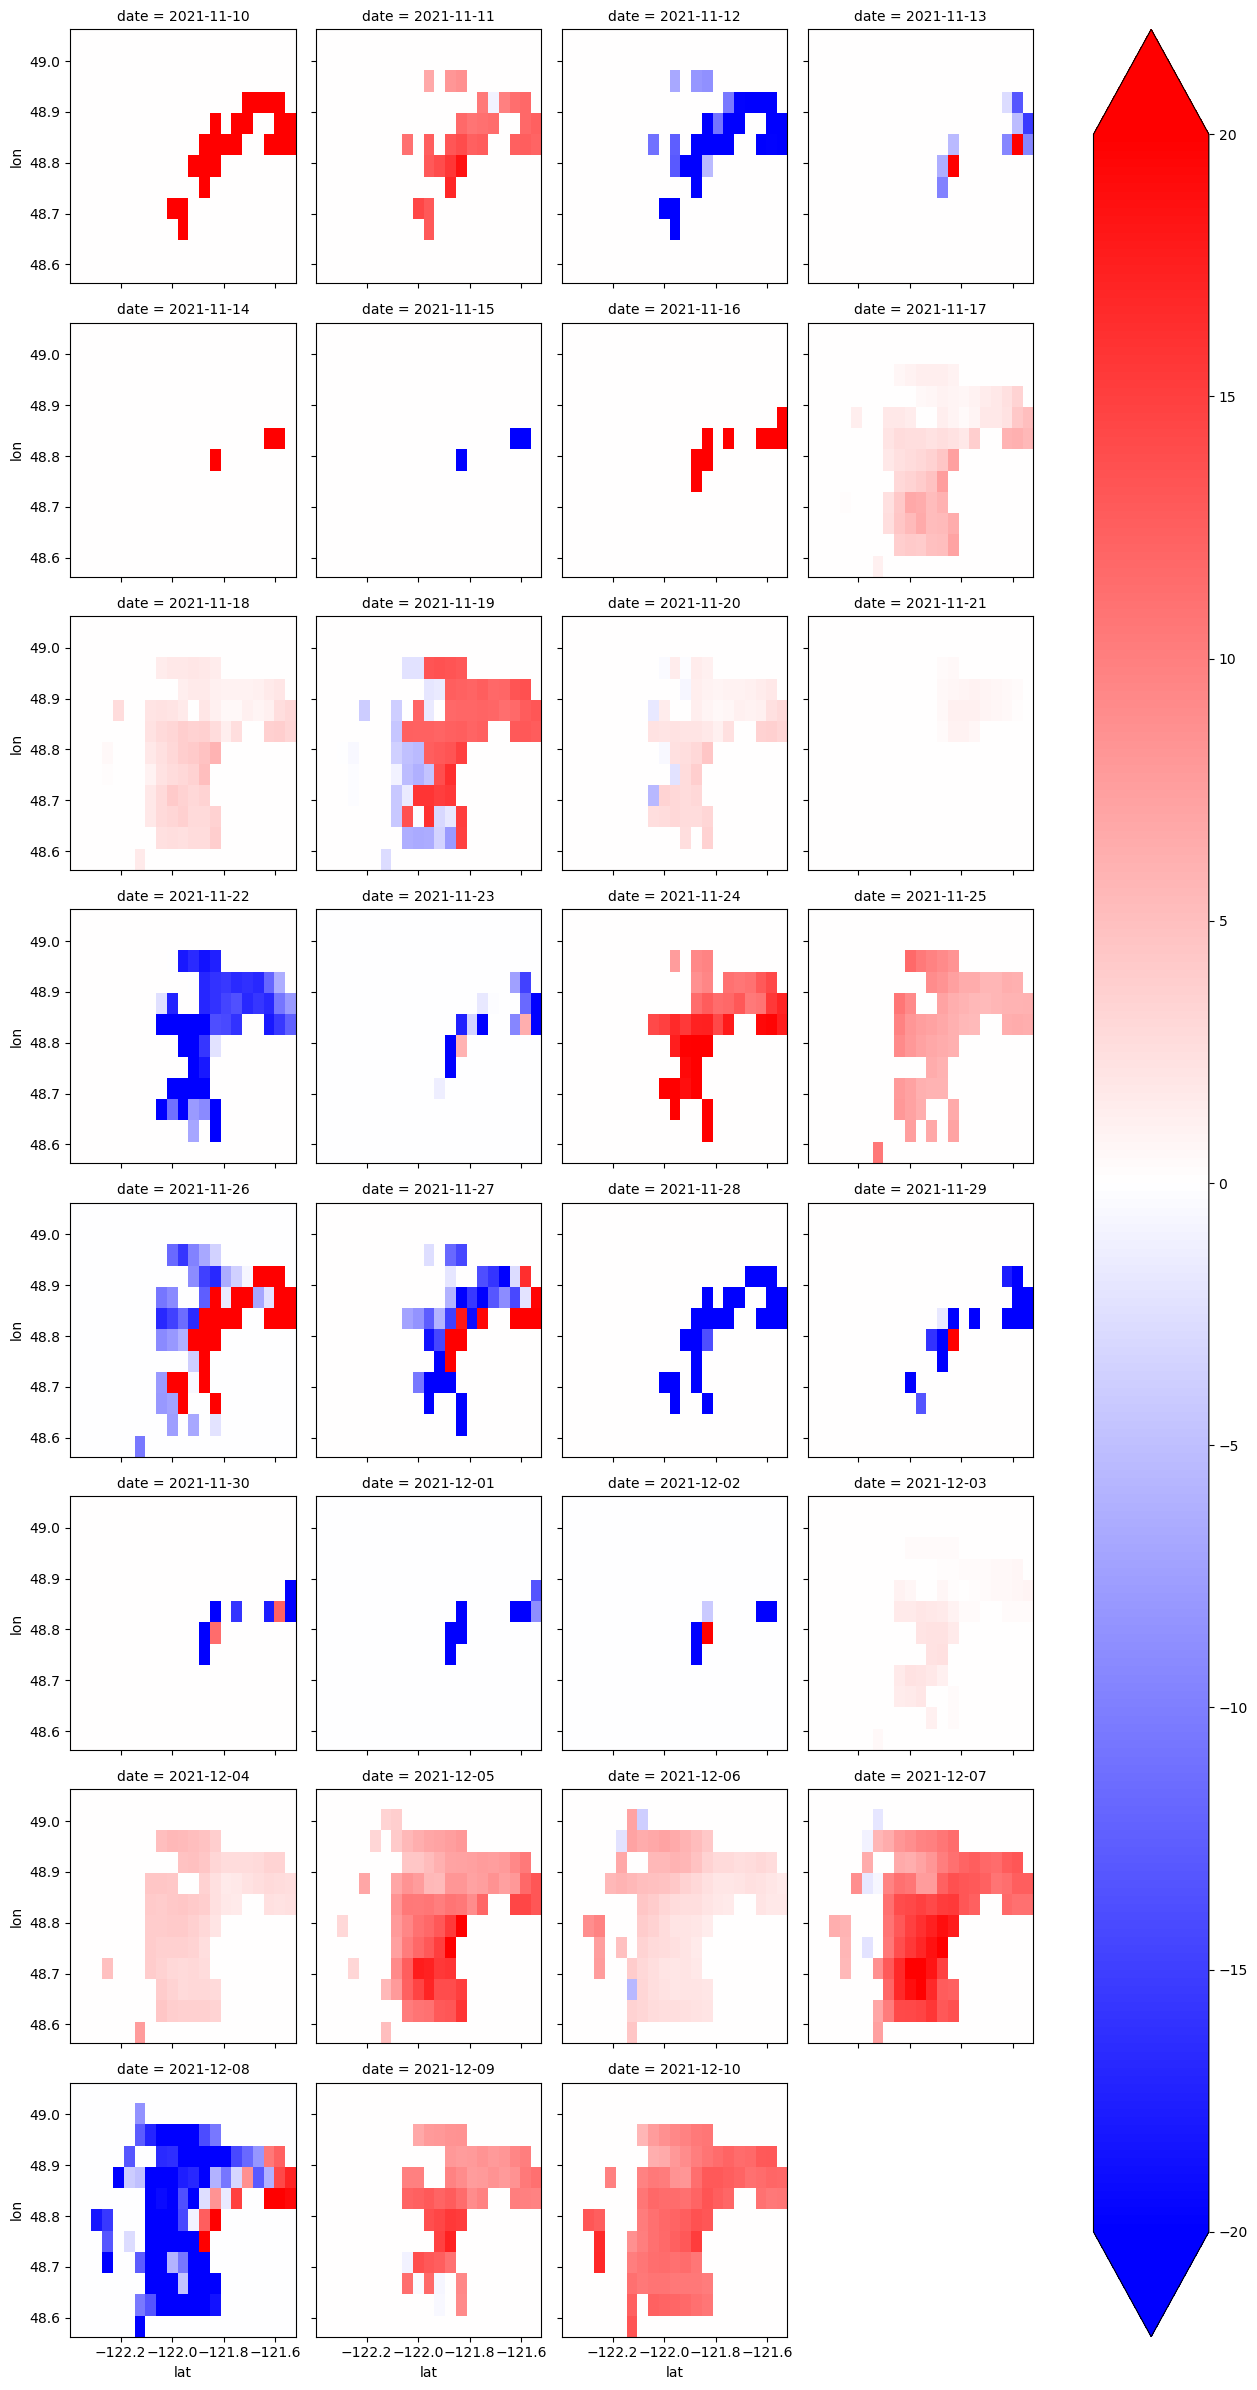

In [13]:
daily_snow_change.isel(date=slice(0, 31, 1)).plot.imshow(col = 'date', col_wrap = 4, 
                                                         vmin = -20, vmax = 20, cmap = 'bwr')